The project also used nltk’s WordNet functions to expand search queries as well as “cv2” and “matplotlib” to visualize images.

In [8]:
import string
import re
from nltk.corpus import stopwords
from IPython.display import display
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2 as cv
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
#from top2vec import Top2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Reupload of a processed version of the dataset to perform search on it without running the previous cells
df = pd.read_csv('/content/searchable_dataset.csv', encoding='utf-8')

In [16]:
df.head()

,Title,Artist,Price,Description,Dimensions,Style,Link,Image,Height,Width,Dimensions in cm2,Themes,Title + Description + Themes,Keywords,Topic,Score
0,Zebra underwater No. 2,Shari Blackwell,60.0,"digital art, watermark will be removed upon pu...",NaN,Modern art,https://anasaea.com/viewArtPiece/wFJmgvhhAstnd...,downloaded_images/wFJmgvhhAstndrvHt_pic1024.jpeg,NaN,NaN,NaN,NaN,"Zebra underwater No. 2 digital art, watermark ...","['zebra', 'underwater', 'removed']",NaN,NaN
1,Fokker DR I,Constantin Baghici,NaN,The scene of a combat clash with the participa...,NaN,Classicism,https://anasaea.com/viewArtPiece/CzpXJcBTZLkZG...,downloaded_images/CzpXJcBTZLkZG6pDW_pic1024.jpeg,NaN,NaN,NaN,NaN,Fokker DR I The scene of a combat clash with t...,"['participation', 'scene', 'combat', 'ace', 'a...",NaN,NaN
2,Dreamer,Mistake Ann,NaN,"When I was a child, I liked to run away from h...",NaN,Surrealism,https://anasaea.com/viewArtPiece/Dubg6zfsEy6hi...,downloaded_images/Dubg6zfsEy6hijoBa_pic1024.jpeg,NaN,NaN,NaN,NaN,"Dreamer When I was a child, I liked to run awa...","['away', 'looked', 'home', 'time', 'liked', 'n...",NaN,NaN
3,Pedro Pascal,Antonella Torquati,650.0,I portrayed him for my daughter :) // This pai...,"Height 40cm, Width 40cm",Contemporary art,https://anasaea.com/viewArtPiece/MiuSEBy6KeFLw...,downloaded_images/MiuSEBy6KeFLwAaQt_pic1024.jpeg,40.0,40.0,1600.0,NaN,Pedro Pascal I portrayed him for my daughter :...,"['portrayed', 'pascal', 'pedro', 'daughter']",NaN,NaN
4,Softly Sunrise,Joseph Liberti,400.0,Sunrise softly tears the sky on Colorado.\n\nF...,"Height 71cm, Width 71cm",Abstract expressionism,https://anasaea.com/viewArtPiece/cozFLQpCp4L22...,downloaded_images/cozFLQpCp4L22yaTg_pic1024.jpeg,71.0,71.0,5041.0,NaN,Softly Sunrise Sunrise softly tears the sky on...,"['return', 'sunrise', 'float', 'continental', ...",58.0,0.972908


In [15]:
def expand_query(query):
    """
    Expand query through synonyms and meronyms

    Args:
    query (str)

    Returns:
    list : a list containing the word(s) of the original query and its synonyms and meronyms from WordNet
    """
    tokens = nltk.word_tokenize(query)
    expanded_query = []
    expanded_query.extend(tokens)

    for token in tokens:
        synonyms = set()
        meronyms = set()
        # Add synonyms to the set
        for synonym in wordnet.synsets(token):
            for lemma in synonym.lemmas():
                if synonym.wup_similarity(wordnet.synsets(token)[0]) >= 0.6:
                    synonyms.add(lemma.name())
            # Add the meronyms to the set
            for meronym in synonym.part_meronyms():
                for lemma in meronym.lemmas():
                    meronyms.add(lemma.name())
            for meronym in synonym.substance_meronyms():
                for lemma in meronym.lemmas():
                    meronyms.add(lemma.name())
        # Add to the expanded query list
        expanded_query.extend(synonyms)
        expanded_query.extend(meronyms)

    # Remove duplicates and convert back to list
    expanded_query = list(set(expanded_query))
    return expanded_query

In [4]:
def getimage(index):
  """
  Display an image of the dataset through its index

  Args:
  index (int): index of the artwork in the DataFrame

  Returns:
  pandas.DataFrame: The filtered DataFrame based on the search criteria defined in the arguments
  """
  try:
    img = df.loc[index, 'Image']
    img = img.replace("downloaded_images/", "")
    title = df.loc[index, 'Title']
    author = df.loc[index, 'Artist']
    try:
      print(f"{title} by {author}")
      image = cv2_imshow(plt.imread(f'/content/drive/MyDrive/Uni/Digital Humanities Lab/digital humanities lab/frontend-nebula/ddr_nebula_2024-main/public/ArtImages/{img}'))
      return image
    except:
      print("Image not available")
  except:
    print("Artwork not in the dataset")



In [5]:
def printmeanprices(df_filtered):
  df_filtered = performsearch(query, style, dimensions, height, width, theme, df)
  # Calculate and print mean price and mean price per square cm
  mean_price = df_filtered['Price'].mean()
  mean_pricecm = (df_filtered['Price']/df_filtered['Dimensions in cm2']).mean()
  print(f"Predicted price: ${mean_price:.2f}")
  print(f"Predicted price per square cm:{mean_pricecm:.2f}")

In [11]:
def performsearch(query, style, dimensions, height, width, theme, df):
  """
  Expand query through synonyms and meronyms

  Args:
  query: style, dimensions, height, width, theme (strings)
  df : the DataFrame containing the dataset of artoworks

  Returns:
  pandas.DataFrame: The filtered DataFrame based on the search criteria defined in the arguments
  """

  # Tokenize the query and expand it through synonyms and meronyms
  querylist = word_tokenize(query)
  expanded_query = expand_query(query)
  keywords = [keyword.lower() for keyword in expanded_query]

  # Normalize textual arguments in lowercase
  style = style.strip().lower()
  dimensions = dimensions.strip().lower()
  theme = theme.strip().lower()
  sort_by_price = None

  # Filter based on keywords in the query
  if query != "":
    cond1 = df['Keywords'].apply(lambda x: any(keyword in x for keyword in keywords))
  else:
    cond1 = True

  # Filter based on specified style
  if style != "":
    cond2 = df['Style'].str.lower().str.contains(style)
  else:
    cond2 = True

  # Filter based on dimensions
  if dimensions == "small":
    cond3 = df['Dimensions in cm2'] < 2500
  elif dimensions == "medium":
    cond3 = (df['Dimensions in cm2'] >= 2500) & (df['Dimensions in cm2'] <= 10000)
  elif dimensions == "large":
    cond3 = df['Dimensions in cm2'] > 10000
  else:
    cond3 = True


  # Filter based on height
  if height != "":
    cond4 = (df['Height'] >= (int(height) - 5)) & (df['Height'] <= (int(height) + 5))
  else:
    cond4 = True

  # Filter based on width
  if width != "":
    cond5 = (df['Width'] >= (int(width) - 5)) & (df['Width'] <= (int(width) + 5))
  else:
    cond5 = True

  # Filter based on themes
  if theme == "landscapes":
    cond6 = df['Topic'].isin([9, 10, 21, 24])

  elif theme == "flowers":
    cond6 = df['Topic'].isin([25])

  elif theme == "sea":
    cond6 = df['Topic'].isin([28])

  elif theme == "animals":
    cond6 = df['Topic'].isin([22, 29, 32, 33, 49, 54])

  elif theme == "universe":
    cond6 = df['Topic'].isin([20, 26])

  elif theme == "nauture":
    cond6 = df['Topic'].isin([12, 19])

  elif theme == "emotions":
    cond6 = df['Topic'].isin([1, 2, 3, 6, 44])

  elif theme == "native americans":
    cond6 = df['Topic'].isin([34])

  elif theme == "love":
    cond6 = df['Topic'].isin([16])

  elif theme == "family":
    cond6 = df['Topic'].isin([43])

  elif theme == "music":
    cond6 = df['Topic'].isin([27])

  elif theme == "vision":
    cond6 = df['Topic'].isin([37])

  elif theme == "women":
    cond6 = df['Topic'].isin([4, 13, 18, 36])

  elif theme == "robots futuristic":
    cond6 = df['Topic'].isin([15])

  elif theme == "urban":
    cond6 = df['Topic'].isin([7, 30, 41,52])
  elif theme == "":
    cond6 = True
    sort_by_price = ""
  # This line creates problem when ran as it is repeated as many times as this function is run.
  else:
    print("The inserted theme is not supported.")


  # Apply filters to the DataFrame
  try:
    df_filtered = df[cond1 & cond2 & cond3 & cond4 & cond5 & cond6]
  except:
    df_filtered = df

  # Sort the DataFrame by topic score if there is a theme filter, otherwise by price.
  if sort_by_price == "":
    df_filtered = df_filtered.sort_values(by='Price')
  else:
    df_filtered = df_filtered.sort_values(by='Score', ascending=False)

  # Return the filtered DataFrame with relevant columns
  return df_filtered


# Example use
query = "loneliness"
style = ""
dimensions = "small"
height = ""
width = ""
theme = "emotions"

results = performsearch(query, style, dimensions, height, width, theme, df)
printmeanprices(results)
display(results[["Title", "Artist", "Price", "Style", "Dimensions", "Keywords"]])

Predicted price: $16666.67
Predicted price per square cm:15.74


,Title,Artist,Price,Style,Dimensions,Keywords
1553,Elvis as oil painting: Lonely,Ollipeka Kangas,20000.0,NaN,"Height 30cm, Width 30cm","['room', 'adoration', 'acknowledged', 'fame', ..."
940,Surreal Loneliness,Ollipeka Kangas,10000.0,Magical Realism,"Height 40cm, Width 30cm","['adoration', 'acknowledged', 'fame', 'basked'..."
537,Elvis Presley in hotel,Ollipeka Kangas,20000.0,Contemporary art,"Height 40cm, Width 30cm","['adoration', 'acknowledged', 'fame', 'basked'..."


Elvis Presley in hotel by Ollipeka Kangas


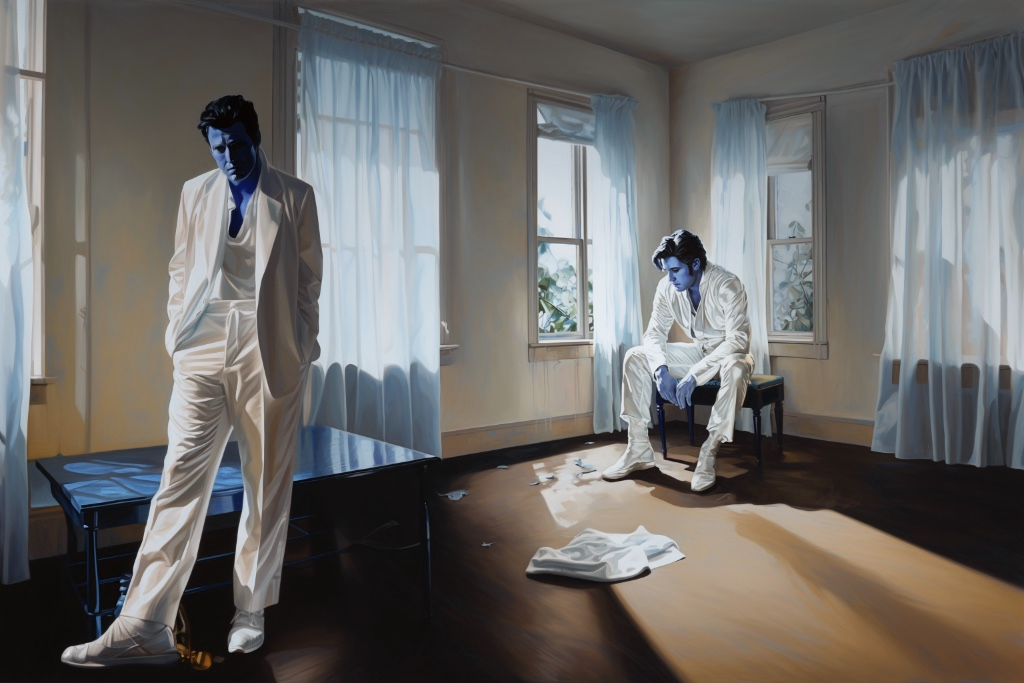

In [ ]:
# Display a random image from the filtered DataFrame
getimage((performsearch(query, style, dimensions, height, width, theme, df)).sample().index[0])


Art Prices Search Engine
Enter your search criteria (leave blank to skip a field):
Enter query: joy memory
Enter style: expressionism
Enter dimensions (small/medium/large): 
Enter height: 
Enter width: 
Enter an available theme:
Landscapes
Flowers
Sea
Animals
Universe
Nature
Emotions
Native Americans
Love
Family
Vision
Women
Robots Futuristic
Urban
Music
Emotions
Predicted price: $16666.67
Predicted price per square cm:15.74


,Title,Artist,Price,Style,Dimensions,Keywords
1559,Visions de variété: Visions of Variety,Calvin Lugalambi,3750.0,Abstract expressionism,"Height 121.92cm, Width 142.24cm","['humanity', 'becomes', 'enveloped', 'possibil..."
963,Éclat d'Émotion: Burst of Emotion,Calvin Lugalambi,3750.0,Abstract expressionism,"Height 121.92cm, Width 142.24cm","[""d'évoquer"", 'pouvoir', 'suggests', ""s'immerg..."
758,Fragmentos,Mizael,10530.0,Abstract expressionism,NaN,"['dare', 'tells', 'glass', 'illusion', 'forgot..."
569,Rythme de Regard: Rhythm of Gaze,Calvin Lugalambi,3750.0,Abstract expressionism,"Height 121.92cm, Width 142.24cm","['mirror', 'becomes', 'stir', 'souls', 'intros..."
425,Blossoming Presence,Heather Dawn Coleman,2250.0,Abstract expressionism,"Height 36cm, Width 24cm","['vitality', 'talented', 'offers', 'stems', 'u..."
1083,Mosaic deART1,Junichi Oboshi,NaN,Abstract expressionism,"Height 50cm, Width 70cm","['name', 'mosaicdeart', 'sophisticated', 'uniq..."


Éclat d'Émotion: Burst of Emotion by Calvin Lugalambi


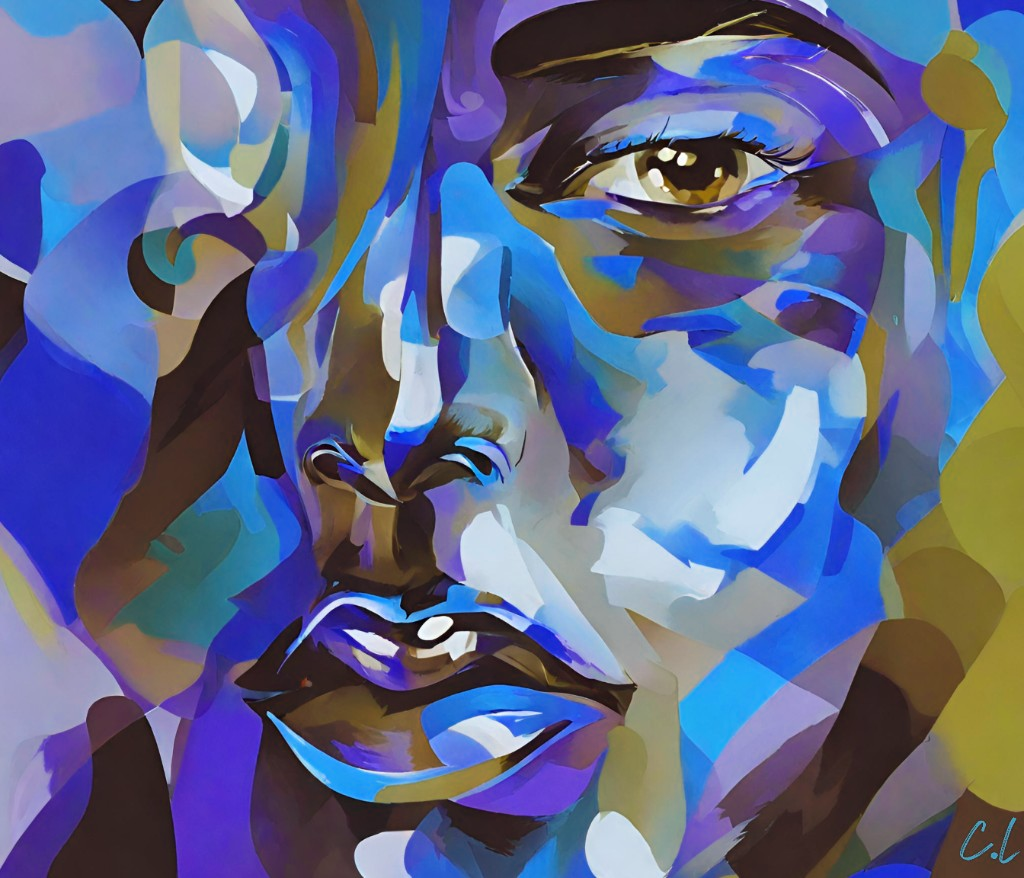


Do you want to perform another search? (y/n): n


In [ ]:
# Proof of concept for the front-end - the way it handles styles and themes is far from optimal due to python limitations.
def nebula():
  while True:
    print("Art Prices Search Engine")
    print("Enter your search criteria (leave blank to skip a field):")

    query = input("Enter query: ")
    style = input("Enter style: ")
    dimensions = input("Enter dimensions (small/medium/large): ")
    height = input("Enter height: ")
    width = input("Enter width: ")
    theme = input("Enter an available theme:\nLandscapes\nFlowers\nSea\nAnimals\nUniverse\nNature\nEmotions\nNative Americans\nLove\nFamily\nVision\nWomen\nRobots Futuristic\nUrban\nMusic\n")

    # Perform search
    results = performsearch(query, style, dimensions, height, width, theme, df)

    # Display results
    printmeanprices(results)
    display(results[["Title", "Artist", "Price", "Style", "Dimensions", "Keywords"]])
    # Display random image from the filtered DataFrame
    getimage((results).sample().index[0])

    # New Search
    newsearch = input("\nDo you want to perform another search? (y/n): ").strip().lower()
    if newsearch != 'y':
      break
nebula()